1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

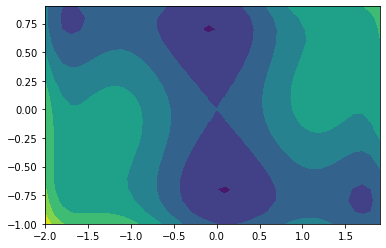

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

def f(x):
    return (4 - 2.1*x[0]**2 + (x[0]**4)/3) * x[0]**2 + x[0]*x[1] + (4*x[1]**2 - 4)*x[1]**2

x = np.arange(-2, +2, 0.1)
y = np.arange(-1, +1, 0.1)

xx, yy = np.meshgrid(x, y, sparse=True)
z = f([xx, yy])

h = plt.contourf(x, y, z)
plt.show()

In [2]:
sol1 = optimize.minimize(f, [-2, -1])
sol2 = optimize.minimize(f, [+2, +1])

In [3]:
# There are two global minima
print(f'Global minimum 1: ({sol1.x[0]}, {sol1.x[1]}) with value: {sol1.fun}')
print(f'Global minimum 2: ({sol2.x[0]}, {sol2.x[1]}) with value: {sol2.fun}')

Global minimum 1: (0.08984183776656297, -0.7126562823479043) with value: -1.0316284534896594
Global minimum 2: (-0.08984185168166231, 0.712656268772178) with value: -1.0316284534896498


In [5]:
# If we use (0, 0) as initial guess we get stuck in a saddle point and we
# don't get the real global minima
sol3 = optimize.minimize(f, [0, 0])
print(sol3)

      fun: 0.0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 5.96046448e-08, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Text(0, 0.5, 'Temperature')

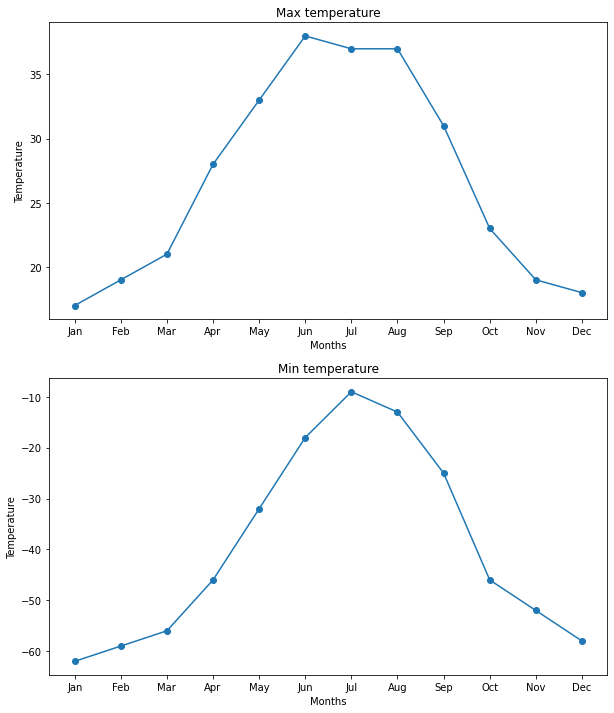

In [54]:
temp_max = [17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18]
temp_min = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

ax1.plot_date(months, temp_max, xdate=True, linestyle='solid')
ax2.plot_date(months, temp_min, xdate=True, linestyle='solid')

ax1.set_title('Max temperature')
ax1.set_xlabel('Months')
ax1.set_ylabel('Temperature')

ax2.set_title('Min temperature')
ax2.set_xlabel('Months')
ax2.set_ylabel('Temperature')

In [64]:
#def gaussian(x, mu, sig):
#    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def gaussian(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

params_max, params_covariance_max = optimize.curve_fit(gaussian, range(12), temp_max, full_output=False)

print('Parameters for max temp')
print('H = %.2f +- %.2f' % (params_max[0], np.sqrt(params_covariance_max[0,0])))
print('A = %.2f +- %.2f' % (params_max[1], np.sqrt(params_covariance_max[1,1])))
print('x0 = %.2f +- %.2f' % (params_max[2], np.sqrt(params_covariance_max[2,2])))
print('Sigma = %.2f +- %.2f\n' % (params_max[3], np.sqrt(params_covariance_max[3,3])))

params_min, params_covariance_min = optimize.curve_fit(gaussian, range(12), temp_min, p0=[1, 1, 5.5, 1], full_output=False)

print('Parameters for min temp')
print('H = %.2f +- %.2f' % (params_min[0], np.sqrt(params_covariance_min[0,0])))
print('A = %.2f +- %.2f' % (params_min[1], np.sqrt(params_covariance_min[1,1])))
print('x0 = %.2f +- %.2f' % (params_min[2], np.sqrt(params_covariance_min[2,2])))
print('Sigma = %.2f +- %.2f' % (params_min[3], np.sqrt(params_covariance_min[3,3])))

Parameters for max temp
H = 15.78 +- 1.18
A = 23.09 +- 1.15
x0 = 5.74 +- 0.08
Sigma = -2.29 +- 0.17

Parameters for min temp
H = -61.32 +- 1.19
A = 52.65 +- 1.40
x0 = 6.16 +- 0.05
Sigma = -1.98 +- 0.08


Text(0, 0.5, 'Temperature')

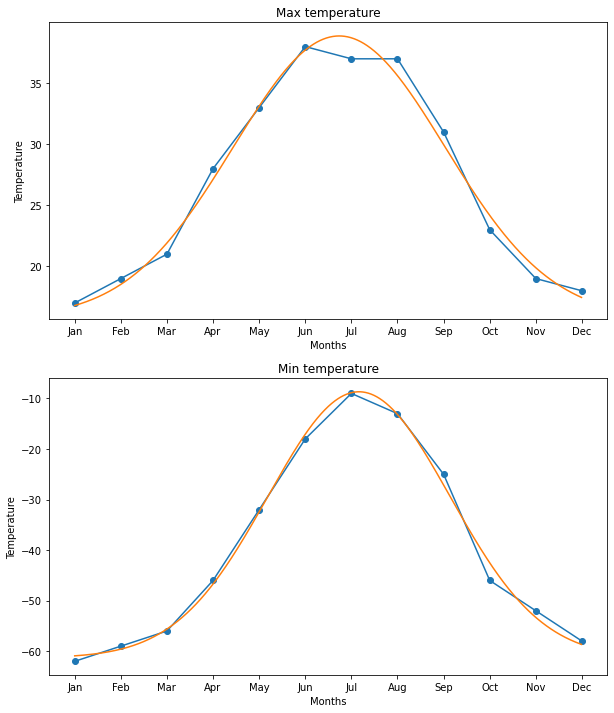

In [65]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

x = np.arange(0, 11, 0.01)

ax1.plot_date(months, temp_max, xdate=True, linestyle='solid')
ax2.plot_date(months, temp_min, xdate=True, linestyle='solid')

ax1.plot(x, gaussian(x, *params_max))
ax2.plot(x, gaussian(x, *params_min))

ax1.set_title('Max temperature')
ax1.set_xlabel('Months')
ax1.set_ylabel('Temperature')

ax2.set_title('Min temperature')
ax2.set_xlabel('Months')
ax2.set_ylabel('Temperature')

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [66]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

--2021-12-08 15:25:29--  https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3uqleyc3wyz52tr/residuals_261.pkl [following]
--2021-12-08 15:25:29--  https://www.dropbox.com/s/raw/3uqleyc3wyz52tr/residuals_261.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2d0e7757674babbd060e896607.dl.dropboxusercontent.com/cd/0/inline/BbfrS3FVXpPqR0I1qO75HjwIYgiHTXbQIP-62Bo-NbdajINVAKjZxHM-QGiC2PhswQzFXW0VYjtgqSz3CvVX70-LpU0SRjKNYbDRbhvFPKT1yIzGfQILoFmnkE3bpE4218lv9zbexaeRxN4nH7ZMxeEe/file# [following]
--2021-12-08 15:25:30--  https://uc2d0e7757674babbd060e896607.dl.dropboxusercontent.com/cd/0/inline/BbfrS3FVXpPqR0I1qO75HjwIYgiHTXbQIP-62Bo-NbdajINVAKjZxHM-QGiC2PhswQzFXW0VYjtgqSz3CvVX70-LpU0SRjKNYbDRb

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

In [67]:
!wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt -P data/

--2021-12-08 15:26:58--  https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt [following]
--2021-12-08 15:26:58--  https://www.dropbox.com/s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce73c82b92a56d3a96e7476dae6.dl.dropboxusercontent.com/cd/0/inline/BbexLCTdFoyTIFOkRlBMcLBX1pChp-Xft0YdxK-euCeQiQh3fxFs83OvZ_MpYxkhB1sZk44YRkR9lGAX84MUZbB6DSEl77THyw5ke-LHkZjjS5Ejhd1BqqospILnBdjCqyXoBQt4MTlmDudANEuHXTwF/file# [following]
--2021-12-08 15:26:58--  https://uce73c82b92a56d3a96e7476dae6.dl.dropboxusercontent.com/cd/0/inline/BbexLCTdFoyTIFOkR

In [140]:
import pandas as pd

df1 = pd.read_csv('data/munich_temperatures_average_with_bad_data.txt', sep=' ', names=['Time', 'Temp'], dtype={'Time': str})
df1[['Year', 'Day']] = df1['Time'].str.split('.', expand=True).astype(int)

df2 = df1[df1['Year'].between(2008, 2012, inclusive=True)]
df2

,Time,Temp,Year,Day
4748,2008.00274,-2.94444,2008,274
4749,2008.00548,-2.66667,2008,548
4750,2008.00821,-2.66667,2008,821
4751,2008.01095,-2.00000,2008,1095
4752,2008.01369,-1.94444,2008,1369
...,...,...,...,...
6569,2012.98836,6.88889,2012,98836
6570,2012.99110,7.05556,2012,99110
6571,2012.99384,3.77778,2012,99384
6572,2012.99658,1.83333,2012,99658


In [141]:
def f1(t, a, b, c):
    return a * np.cos(2*np.pi*t + b) + c

def f2(t, a, b, c, d):
    return a * np.cos(2*np.pi*b*t + c) + d

In [142]:
len(df2)

1826

In [146]:
params, params_covariance = optimize.curve_fit(f2, list(range(len(df2))), df2['Temp'], full_output=False)

print('Parameters')
print('a = %.2f +- %.2f' % (params[0], np.sqrt(params_covariance[0,0])))
print('b = %.2f +- %.2f' % (params[1], np.sqrt(params_covariance[1,1])))
print('c = %.2f +- %.2f' % (params[2], np.sqrt(params_covariance[2,2])))

Parameters
a = 11.20 +- 541668.49
b = 1.00 +- 0.12
c = 1.67 +- 3699.53


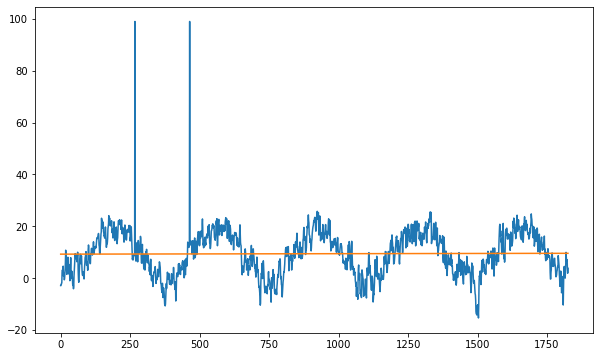

In [148]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(list(range(len(df2))), df2['Temp'])
ax.plot(list(range(len(df2))), f2(np.array(range(len(df2))), *params))

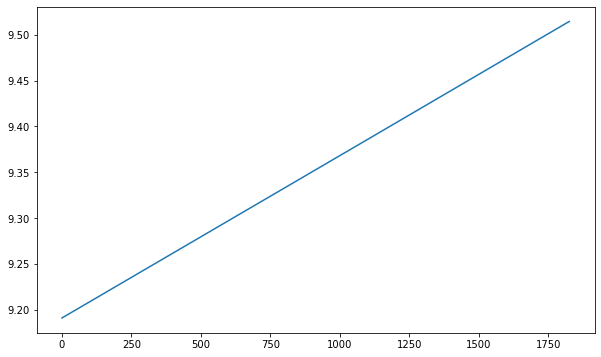

In [150]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(list(range(len(df2))), f2(np.array(range(len(df2))), *params))